In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Momentum SGD with Three Army Classification

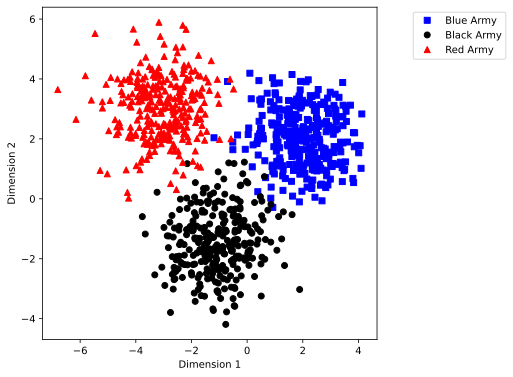

In [2]:
nPerClust = 300

A = [2, 2]
B = [-1, -1.5]
C = [-3, 3]
np.random.seed(20)
a = [A[0]+np.random.randn(nPerClust), A[1]+np.random.randn(nPerClust)]
b = [B[0]+np.random.randn(nPerClust), B[1]+np.random.randn(nPerClust)]
c = [C[0]+np.random.randn(nPerClust), C[1]+np.random.randn(nPerClust)]

labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1)), np.ones((nPerClust, 1))+1))
data_np = np.hstack((a, b, c)).T

data_tensor = torch.tensor(data_np).float()
labels_tensor = torch.squeeze(torch.tensor(labels_np).long())

plt.figure(figsize=(6,6))
plt.plot(data_tensor[np.where(labels_tensor==0)[0],0],data_tensor[np.where(labels_tensor==0)[0],1],'bs')
plt.plot(data_tensor[np.where(labels_tensor==1)[0],0],data_tensor[np.where(labels_tensor==1)[0],1],'ko')
plt.plot(data_tensor[np.where(labels_tensor==2)[0],0],data_tensor[np.where(labels_tensor==2)[0],1],'r^')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(["Blue Army", "Black Army", "Red Army"], bbox_to_anchor=(1.4,1));

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [4]:
def modelWithMomentum(momentum):

    armyClassy = nn.Sequential(nn.Linear(2, 8), nn.ReLU(), nn.Linear(8, 8), nn.ReLU(), nn.Linear(8, 3))
    
    loss_fun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(armyClassy.parameters(), momentum=momentum, lr=0.01)
    
    return armyClassy, loss_fun, optimizer

In [5]:
num_epochs = 100

def trainModel(momentum):

    armyClassy, loss_fun, optimizer = modelWithMomentum(momentum)
    
    losses = torch.zeros(num_epochs)
    train_acc = []
    test_acc = []
    
    for epoch in range(num_epochs):
        armyClassy.train()
        
        batch_acc = []
        batch_loss = []
        
        for x, y in train_loader:
            y_hat = armyClassy(x)
            
            loss = loss_fun(y_hat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
            batch_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()))
            
        train_acc.append(np.mean(batch_acc))
        losses[epoch] = np.mean(batch_loss)
        
        armyClassy.eval()
        x, y = next(iter(test_loader))
        with torch.no_grad():
            test_acc.append(100*torch.mean((torch.argmax(armyClassy(x), axis=1) == y).float()))
        
    return train_acc, test_acc, losses

In [6]:
momentum = [0, 0.5, 0.9, 0.95, 0.999]

results = np.zeros((num_epochs, len(momentum), 3))

for i, moment in enumerate(momentum):
    train_acc, test_acc, losses = trainModel(moment)
    results[:, i, 0] = train_acc
    results[:, i, 1] = test_acc
    results[:, i, 2] = losses

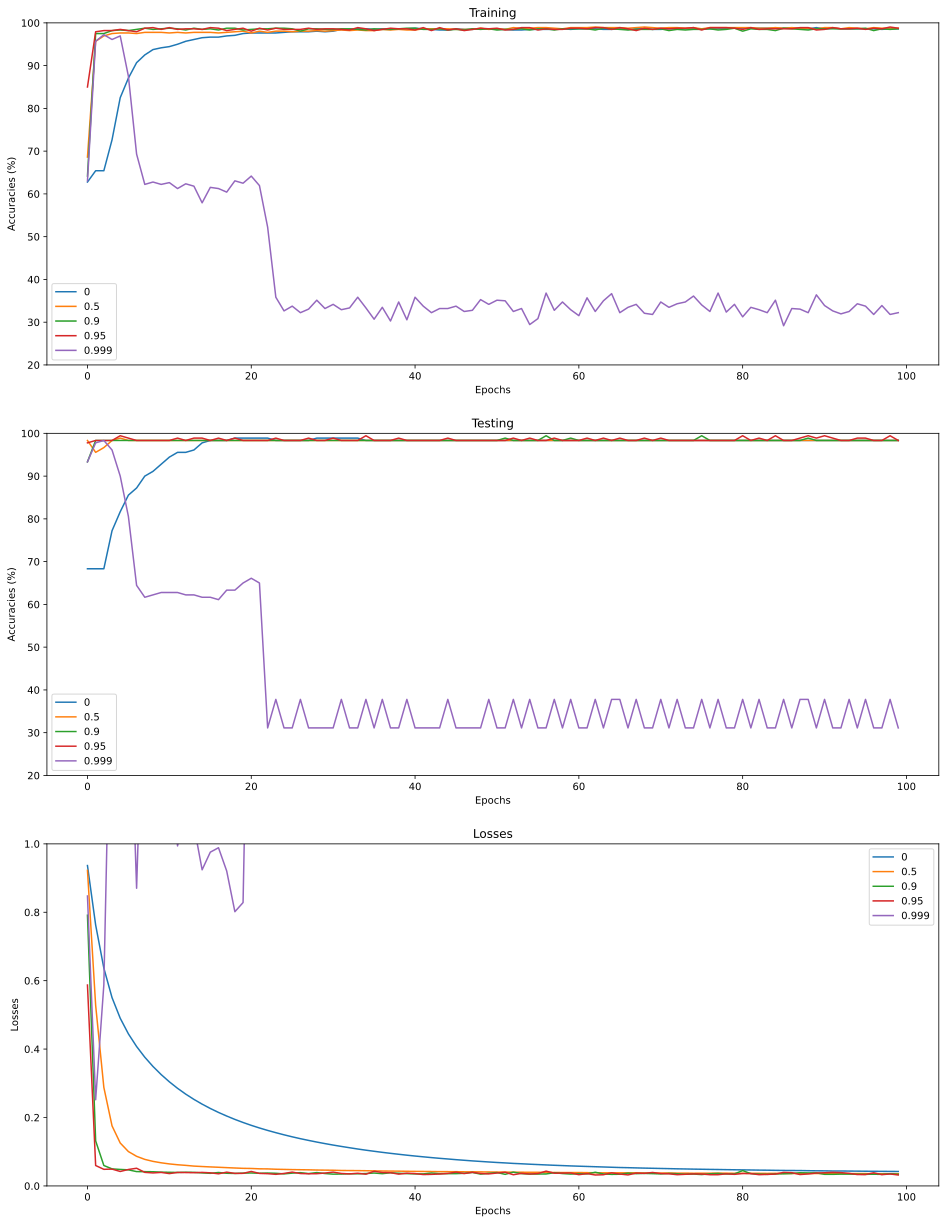

In [7]:
_, axis = plt.subplots(3, 1, figsize=(16, 21))

for i in range(3):
    axis[i].plot(results[:, :, i])
    axis[i].legend(momentum)
    axis[i].set_xlabel("Epochs")
    if i == 2:
        axis[i].set_ylabel("Losses")
    else:
        axis[i].set_ylabel("Accuracies (%)")
        axis[i].set_ylim([20, 100])

axis[2].set_ylim([0, 1])

axis[0].set_title("Training")
axis[1].set_title("Testing")
axis[2].set_title("Losses");

# Comparison between the SGD, RMSprop and Adam

In [8]:
def modelWithOptimizer(optimizer_var):

    armyClassy = nn.Sequential(nn.Linear(2, 8), nn.ReLU(), nn.Linear(8, 8), nn.ReLU(), nn.Linear(8, 3))

    loss_fun = nn.CrossEntropyLoss()

    opti_fun = getattr(torch.optim, optimizer_var)
    optimizer = opti_fun(armyClassy.parameters(), lr=0.01)

    return armyClassy, loss_fun, optimizer

In [9]:
num_epochs = 100

def trainModel(optimizer_var):

    armyClassy, loss_fun, optimizer = modelWithOptimizer(optimizer_var=optimizer_var)

    losses = torch.zeros(num_epochs)
    train_acc = []
    test_acc = []

    for epoch in range(num_epochs):
        armyClassy.train()

        batch_acc = []
        batch_loss = []

        for x, y in train_loader:
            y_hat = armyClassy(x)

            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())

            batch_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()))

        train_acc.append(np.mean(batch_acc))
        losses[epoch] = np.mean(batch_loss)

        armyClassy.eval()
        x, y = next(iter(test_loader))
        with torch.no_grad():
            test_acc.append(100*torch.mean((torch.argmax(armyClassy(x), axis=1) == y).float()))

    return train_acc, test_acc, losses, armyClassy

In [10]:
def plotResults(optimizer_var, armyClassy, train_acc, test_acc, losses):
    y_hat = armyClassy(data_tensor)
    accuracy = (torch.argmax(y_hat, axis=1) == labels_tensor).float()
    total_acc = 100*torch.mean(accuracy).item()
    
    accuracy_by_group = np.zeros(3)
    for i in range(3):
        accuracy_by_group[i] = 100*torch.mean(accuracy[labels_tensor == i])

    fig, axis = plt.subplots(2, 2, figsize=(13, 12))
    fig.suptitle(f"Optimizer: {optimizer_var}", fontsize=20)
    axis[0, 0].plot(losses.detach())
    axis[0, 0].set_ylabel("Losses")
    axis[0, 0].set_xlabel("Epochs")
    axis[0, 0].set_title("Losses")
    
    axis[0, 1].plot(train_acc, label="Train")
    axis[0, 1].plot(test_acc, label="Test")
    axis[0, 1].set_ylabel("Accuracy (%)")
    axis[0, 1].set_xlabel("Epochs")
    axis[0, 1].set_title("Accuracy")
    
    axis[1, 0].bar(range(3), accuracy_by_group)
    axis[1, 0].set_ylim([np.min(accuracy_by_group)-5, np.max(accuracy_by_group)+5])
    axis[1, 0].set_xticks([0, 1, 2])
    axis[1, 0].set_ylabel("Accuracy (%)")
    axis[1, 0].set_xlabel("Groups")
    axis[1, 0].set_title("Accuracy by Group")
    axis[1, 0].set_ylim([20, 100])

    color_shapes = ['bs', 'ko', 'g^']
    
    for i in range(3):
        axis[1, 1].plot(data_tensor[labels_tensor == i, 0], data_tensor[labels_tensor == i, 1], color_shapes[i], label=f"Group {i}")
    
        indexError = (accuracy == 0) & (labels_tensor == i)
        axis[1, 1].plot(data_tensor[indexError, 0], data_tensor[indexError, 1], 'rx')
    
    axis[1, 1].set_ylabel("Dimension 2")
    axis[1, 1].set_xlabel("Dimension 1")
    axis[1, 1].legend()
    axis[1, 1].set_title(f"Total Accuracy: {total_acc: 0.2f}%")
    
    plt.tight_layout()

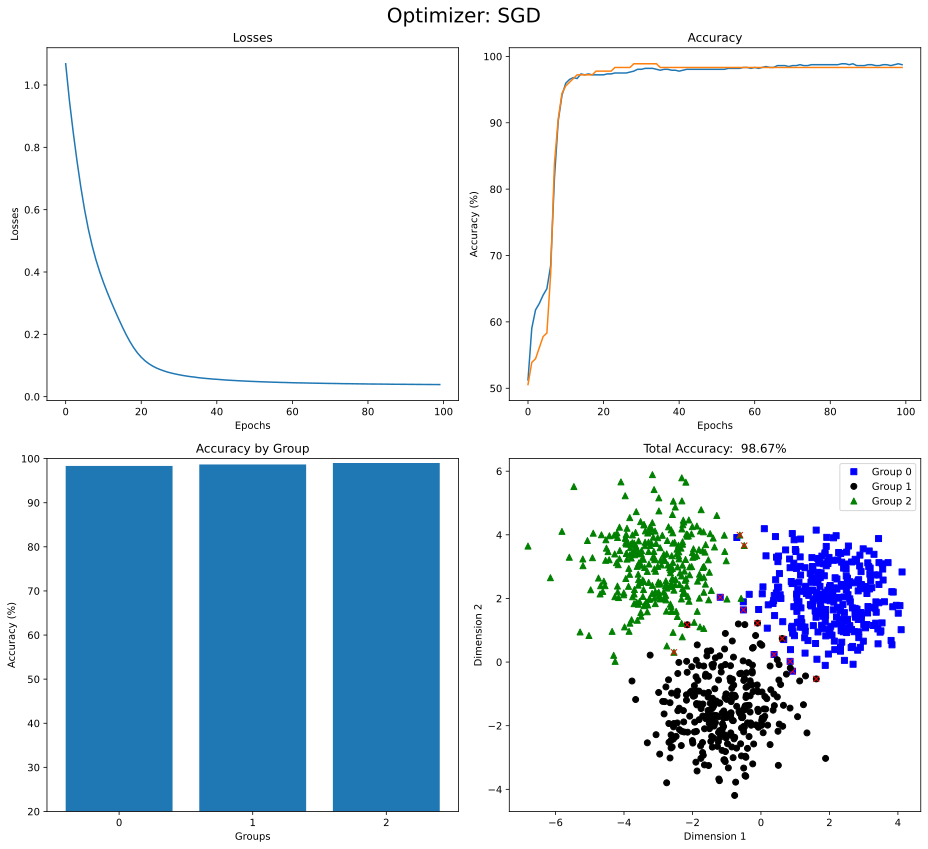

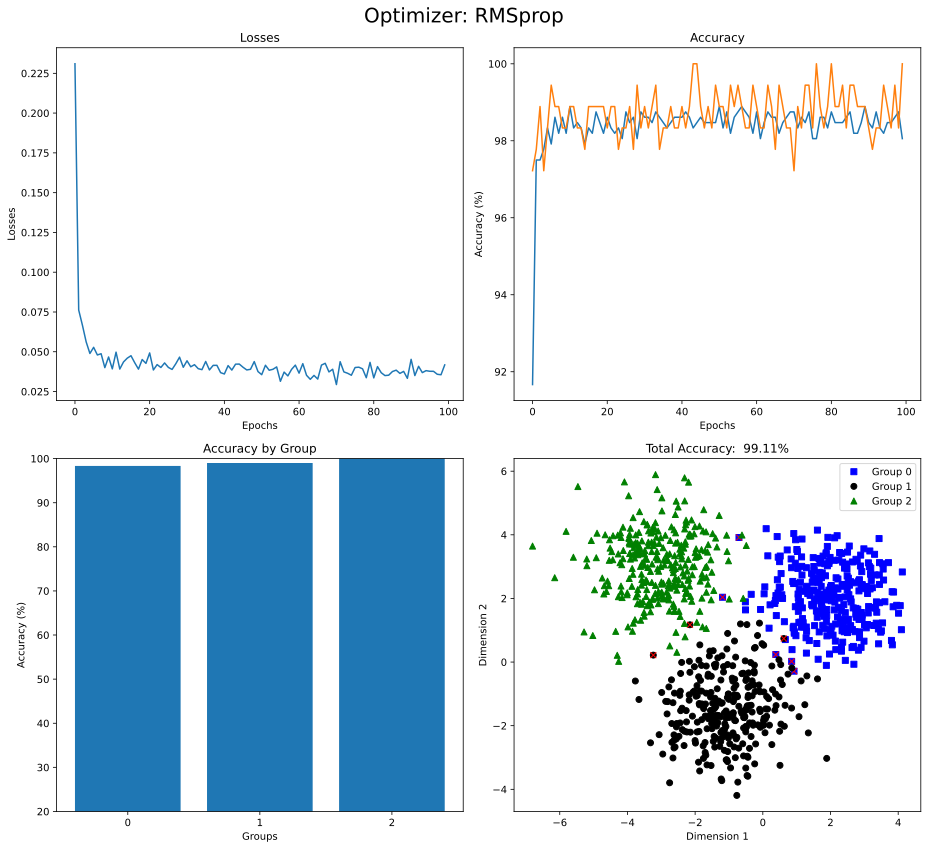

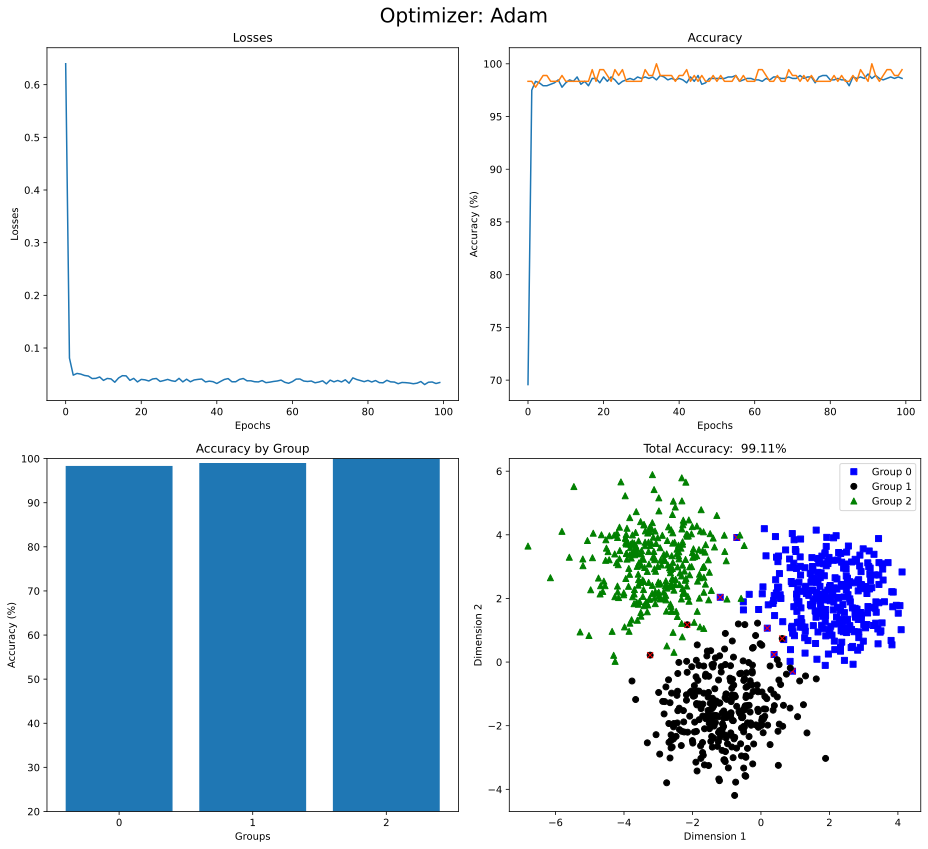

In [11]:
optimizers = ["SGD", "RMSprop", "Adam"]

performance = []

for i, optimizer in enumerate(optimizers):
    train_acc, test_acc, losses, armyClassy = trainModel(optimizer)
    plotResults(optimizer, armyClassy, train_acc, test_acc, losses)
    train = np.mean(train_acc[-10:])
    test = np.mean(test_acc[-10:])
    performance.append(f"{optimizer}: train {train:0.2f}% and test {test:0.2f}%")

In [12]:
performance

['SGD: train 98.72% and test 98.33%',
 'RMSprop: train 98.44% and test 98.72%',
 'Adam: train 98.69% and test 99.06%']

# Comparison of optimizers by learning rate

In [13]:
def modelWithOptimizerAndLR(optimizer_var, lr):

    armyClassy = nn.Sequential(nn.Linear(2, 8), nn.ReLU(), nn.Linear(8, 8), nn.ReLU(), nn.Linear(8, 3))

    loss_fun = nn.CrossEntropyLoss()

    opti_fun = getattr(torch.optim, optimizer_var)
    optimizer = opti_fun(armyClassy.parameters(), lr=lr)

    return armyClassy, loss_fun, optimizer

In [14]:
num_epochs = 100

def trainModel(optimizer_var, lr):

    armyClassy, loss_fun, optimizer = modelWithOptimizerAndLR(optimizer_var, lr)

    test_acc = []

    for epoch in range(num_epochs):
        armyClassy.train()

        for x, y in train_loader:
            y_hat = armyClassy(x)

            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        armyClassy.eval()
        x, y = next(iter(test_loader))
        with torch.no_grad():
            test_acc.append(100*torch.mean((torch.argmax(armyClassy(x), axis=1) == y).float()))

    return test_acc

In [15]:
optimizers = ["SGD", "RMSprop", "Adam"]
learning_rates = np.logspace(np.log10(0.0001), np.log10(0.1), 20)

performance_last = np.zeros((len(learning_rates), len(optimizers)))
performance_first = np.zeros((len(learning_rates), len(optimizers)))

for io, optimizer in enumerate(optimizers):
    for ilr, learning_rate in enumerate(learning_rates):
        test_acc = trainModel(optimizer, learning_rate)
        performance_last[ilr, io] = np.mean(test_acc[-10:])
        performance_first[ilr, io] = np.mean(test_acc[:10])

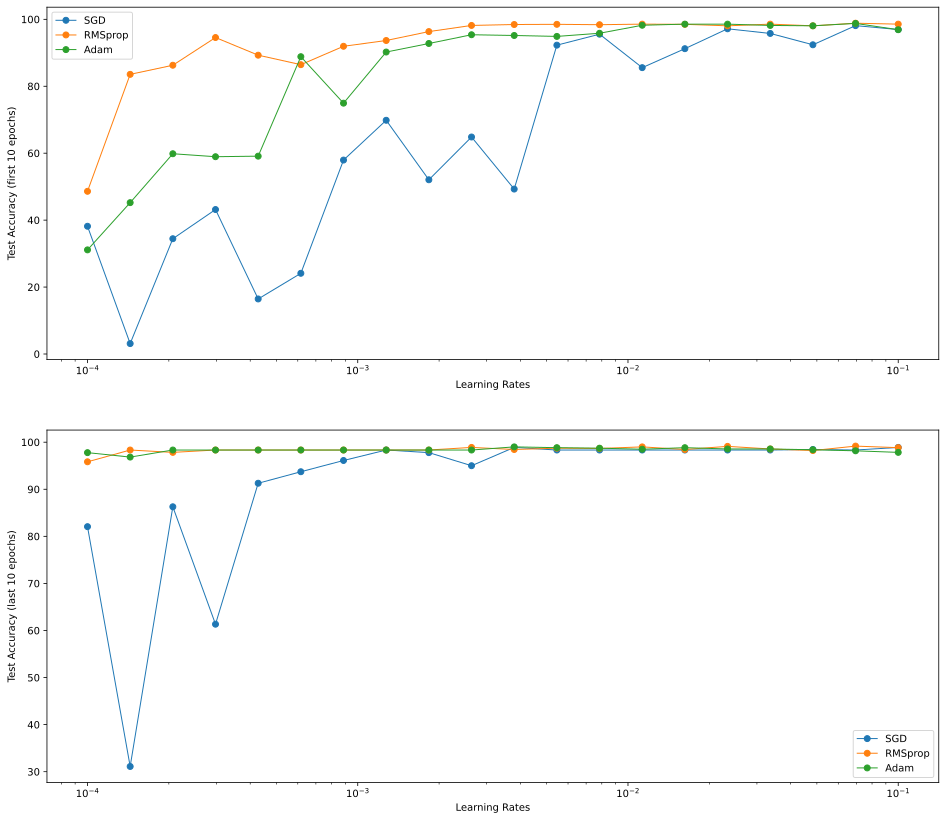

In [16]:
_, axis = plt.subplots(2, 1, figsize=(16, 14))

axis[0].plot(learning_rates, performance_first, 'o-', linewidth=1)
axis[1].plot(learning_rates, performance_last, 'o-', linewidth=1)
axis[0].set_ylabel("Test Accuracy (first 10 epochs)")
axis[1].set_ylabel("Test Accuracy (last 10 epochs)")

for i in range(2):
    axis[i].legend(optimizers)
    axis[i].set_xlabel("Learning Rates")
    axis[i].set_xscale("log")

# Adam with L2 Regularization

In [17]:
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [18]:
def modelWithAdamAndL2(lambda_l2):

    armyClassy = nn.Sequential(nn.Linear(2, 8), nn.ReLU(), nn.Linear(8, 8), nn.ReLU(), nn.Linear(8, 3))

    loss_fun = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(armyClassy.parameters(), lr=0.001, weight_decay=lambda_l2)

    return armyClassy, loss_fun, optimizer

In [19]:
num_epochs = 100

def trainModel(lambda_l2):

    armyClassy, loss_fun, optimizer = modelWithAdamAndL2(lambda_l2)

    train_acc = []
    test_acc = []

    for epoch in range(num_epochs):
        armyClassy.train()

        batch_acc = []
        
        for x, y in train_loader:
            y_hat = armyClassy(x)

            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()))
        
        train_acc.append(np.mean(batch_acc))

        armyClassy.eval()
        x, y = next(iter(test_loader))
        with torch.no_grad():
            test_acc.append(100*torch.mean((torch.argmax(armyClassy(x), axis=1) == y).float()))

    return train_acc, test_acc

In [20]:
lambda_l2s = np.linspace(0.0, 0.1, 6)

train = np.zeros((num_epochs, len(lambda_l2s)))
test = np.zeros((num_epochs, len(lambda_l2s)))

for i, lambda_l2 in enumerate(lambda_l2s):
    train_acc, test_acc = trainModel(lambda_l2)
    train[:, i] = train_acc
    test[:, i] = test_acc

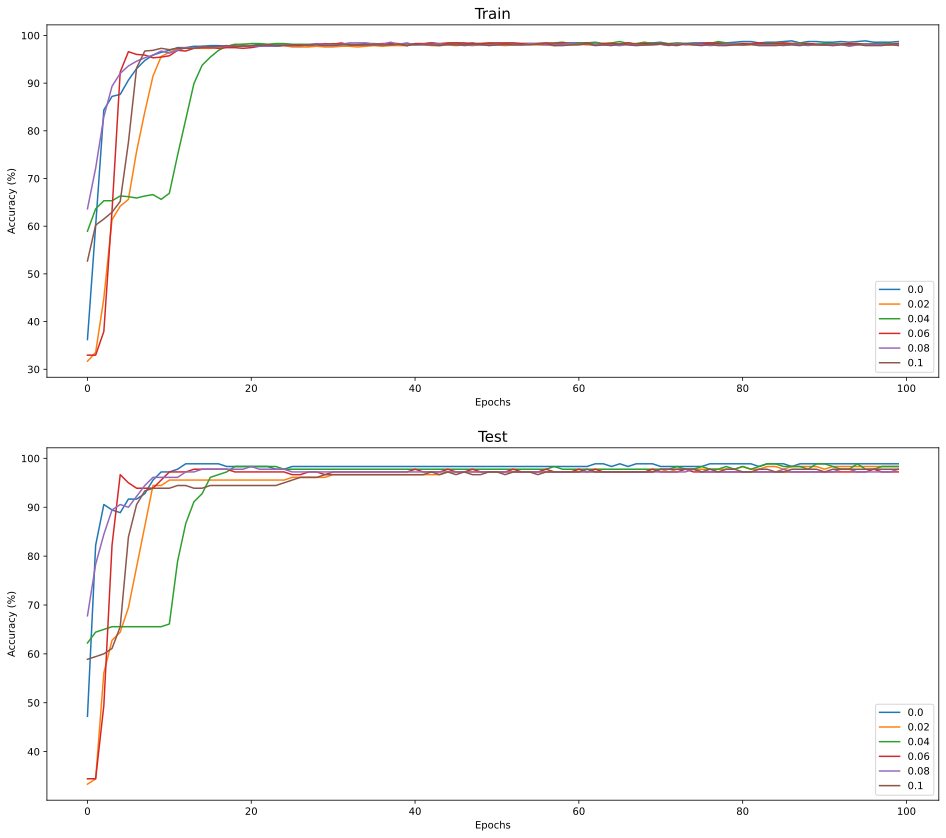

In [21]:
_, axis = plt.subplots(2, 1, figsize=(16, 14))

axis[0].plot(train)
axis[0].set_title("Train", fontsize=15)
axis[1].plot(test)
axis[1].set_title("Test", fontsize=15)

for i in range(2):
    axis[i].legend(lambda_l2s)
    axis[i].set_ylabel("Accuracy (%)")
    axis[i].set_xlabel("Epochs")

# Learning Rate Decay

In [22]:
def modelLRDecay(initial_lr):

    armyClassy = nn.Sequential(nn.Linear(2, 8), nn.ReLU(), nn.Linear(8, 8), nn.ReLU(), nn.Linear(8, 3))

    loss_fun = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(armyClassy.parameters(), lr=initial_lr)
    step_size = 16*len(train_loader)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)

    return armyClassy, loss_fun, optimizer, scheduler

In [23]:
num_epochs = 50

def trainModel(initial_lr, dynamic_lr):

    armyClassy, loss_fun, optimizer, scheduler = modelLRDecay(initial_lr)

    losses = torch.zeros(num_epochs)
    train_acc = []
    test_acc = []
    current_lr = []

    for epoch in range(num_epochs):
        armyClassy.train()

        batch_acc = []
        batch_loss = []

        for x, y in train_loader:
            y_hat = armyClassy(x)

            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if dynamic_lr:
                scheduler.step()
            
            batch_loss.append(loss.item())

            batch_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()))
            
            current_lr.append(scheduler.get_last_lr()[0])

        train_acc.append(np.mean(batch_acc))

        losses[epoch] = np.mean(batch_loss)
        
        armyClassy.eval()
        x, y = next(iter(test_loader))
        with torch.no_grad():
            test_acc.append(100*torch.mean((torch.argmax(armyClassy(x), axis=1) == y).float()))

    return train_acc, test_acc, losses, current_lr

In [24]:
train_acc_static, test_acc_static, losses_static, current_lr_static = trainModel(0.01, True)
train_acc_dynamic, test_acc_dynamic, losses_dynamic, current_lr_dynamic = trainModel(0.01, False)

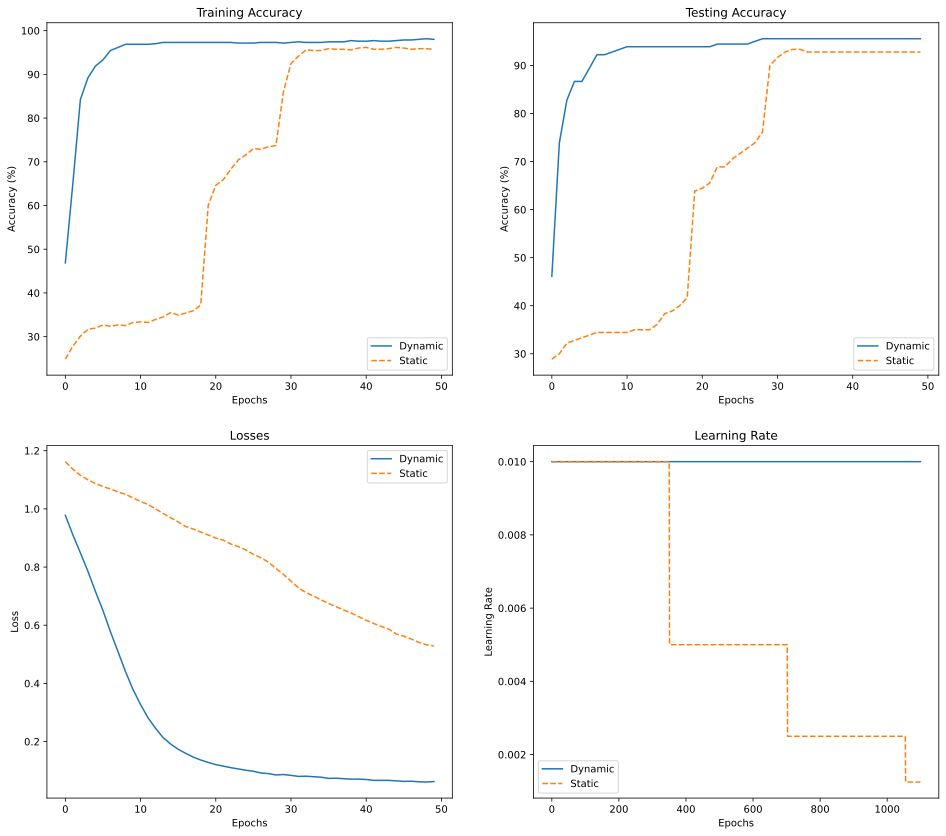

In [25]:
_, axis = plt.subplots(2, 2, figsize=(16, 14))

axis[0, 0].plot(train_acc_dynamic, label="Dynamic")
axis[0, 0].plot(train_acc_static, '--', label="Static")
axis[0, 0].legend()
axis[0, 0].set_title("Training Accuracy")
axis[0, 0].set_xlabel("Epochs")
axis[0, 0].set_ylabel("Accuracy (%)")

axis[0, 1].plot(test_acc_dynamic, label="Dynamic")
axis[0, 1].plot(test_acc_static, '--', label="Static")
axis[0, 1].legend()
axis[0, 1].set_title("Testing Accuracy")
axis[0, 1].set_xlabel("Epochs")
axis[0, 1].set_ylabel("Accuracy (%)")

axis[1, 0].plot(losses_dynamic, label="Dynamic")
axis[1, 0].plot(losses_static, '--', label="Static")
axis[1, 0].legend()
axis[1, 0].set_title("Losses")
axis[1, 0].set_xlabel("Epochs")
axis[1, 0].set_ylabel("Loss")

axis[1, 1].plot(current_lr_dynamic, label="Dynamic")
axis[1, 1].plot(current_lr_static, '--', label="Static")
axis[1, 1].legend()
axis[1, 1].set_title("Learning Rate")
axis[1, 1].set_xlabel("Epochs")
axis[1, 1].set_ylabel("Learning Rate");